In [19]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from textblob import TextBlob
import re
import spacy
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split

In [20]:
df = pd.read_csv('train_tweets.csv')

In [21]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
nombre_doublons = df['text'].duplicated().sum()
print(f"Doublons dans la colonne 'text' du DataFrame : {nombre_doublons}")

df = df.drop_duplicates(subset='text', keep='first')

Doublons dans la colonne 'text' du DataFrame : 110


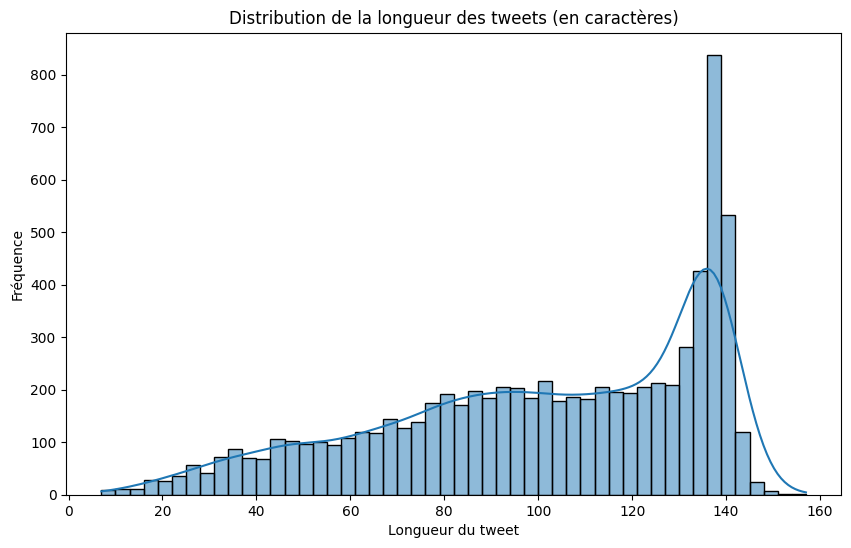

In [23]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution de la longueur des tweets (en caractères)')
plt.xlabel('Longueur du tweet')
plt.ylabel('Fréquence')
plt.show()

Ce graphique illustre la distribution de la longueur des tweets mesurée en caractères :

Axe des Abscisses (X) : Longueur des tweets en caractères. Axe des Ordonnées (Y) : Fréquence des tweets pour chaque longueur. Observations

Forme de la Distribution :

Les tweets augmentent progressivement en longueur jusqu'à un pic significatif à 140 caractères. La majorité des tweets se situent entre 20 et 140 caractères. Pic Principal :

Le pic se trouve autour de 140 caractères, indiquant que de nombreux utilisateurs maximisent la longueur autorisée des tweets. Densité de la Distribution :

La courbe KDE montre une estimation lissée, confirmant que 140 caractères est la longueur la plus courante. Ce graphique montre que les utilisateurs tendent à utiliser la totalité de l'espace disponible pour leurs tweets.

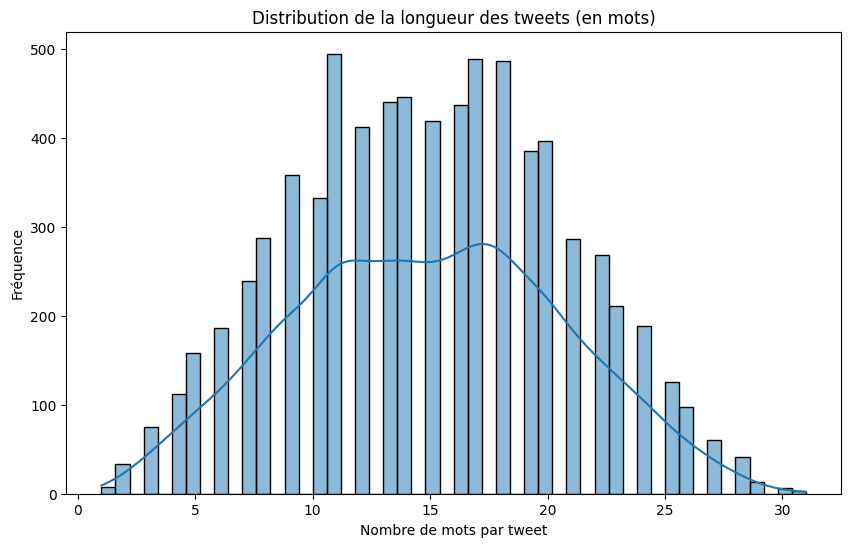

In [24]:
# Distribution de la longueur des tweets (en mots)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution de la longueur des tweets (en mots)')
plt.xlabel('Nombre de mots par tweet')
plt.ylabel('Fréquence')
plt.show()

Ce graphique illustre la distribution de la longueur des tweets mesurée en nombre de mots :

Axe des Abscisses (X) : Nombre de mots par tweet. Axe des Ordonnées (Y) : Fréquence des tweets pour chaque nombre de mots. Observations

Forme de la Distribution :

La distribution montre une augmentation progressive du nombre de tweets jusqu'à environ 15 mots, suivie d'une diminution. Les tweets les plus courants contiennent entre 10 et 20 mots. Pic Principal :

Le pic se trouve autour de 15 mots, indiquant que la majorité des tweets sont assez courts mais expressifs. Densité de la Distribution :

La courbe KDE montre une estimation lissée de la densité de probabilité, confirmant que 15 mots est la longueur la plus courante pour les tweets. Ce graphique montre que la plupart des utilisateurs tendent à rédiger des tweets concis mais informatifs, généralement entre 10 et 20 mots.

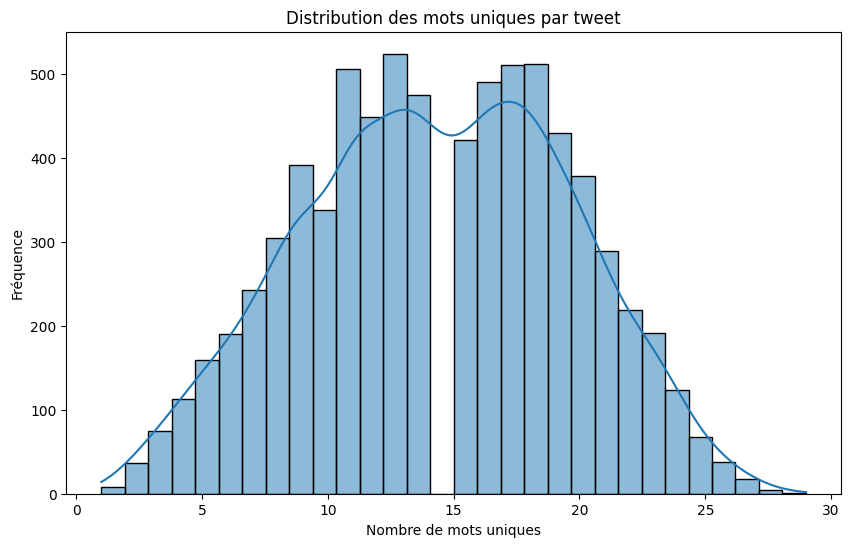

In [25]:
# Distribution des mots uniques par tweet
df['unique_words'] = df['text'].apply(lambda x: len(set(x.split())))
plt.figure(figsize=(10, 6))
sns.histplot(df['unique_words'], bins=30, kde=True)
plt.title('Distribution des mots uniques par tweet')
plt.xlabel('Nombre de mots uniques')
plt.ylabel('Fréquence')
plt.show()

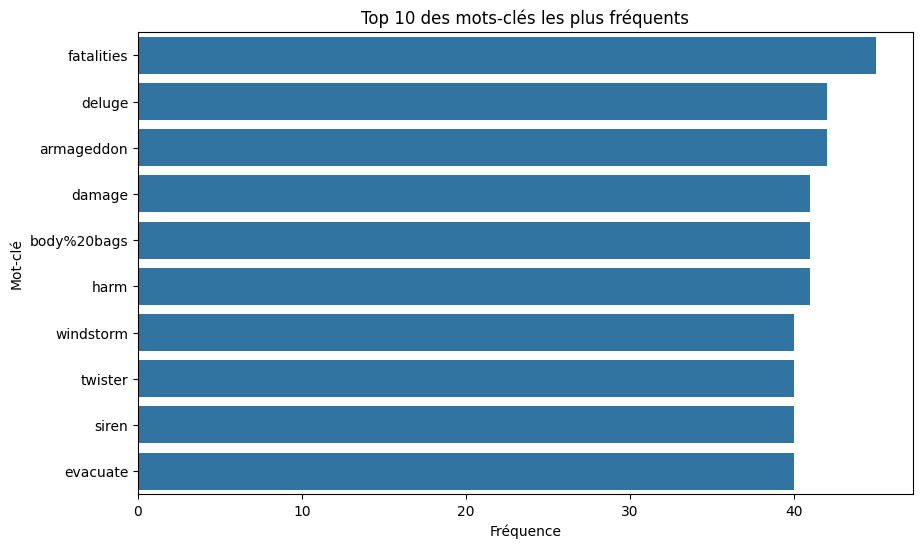

In [26]:
# Distribution des mots-clés (keywords)
plt.figure(figsize=(10, 6))
sns.countplot(y='keyword', data=df, order=df['keyword'].value_counts().iloc[:10].index)
plt.title('Top 10 des mots-clés les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Mot-clé')
plt.show()

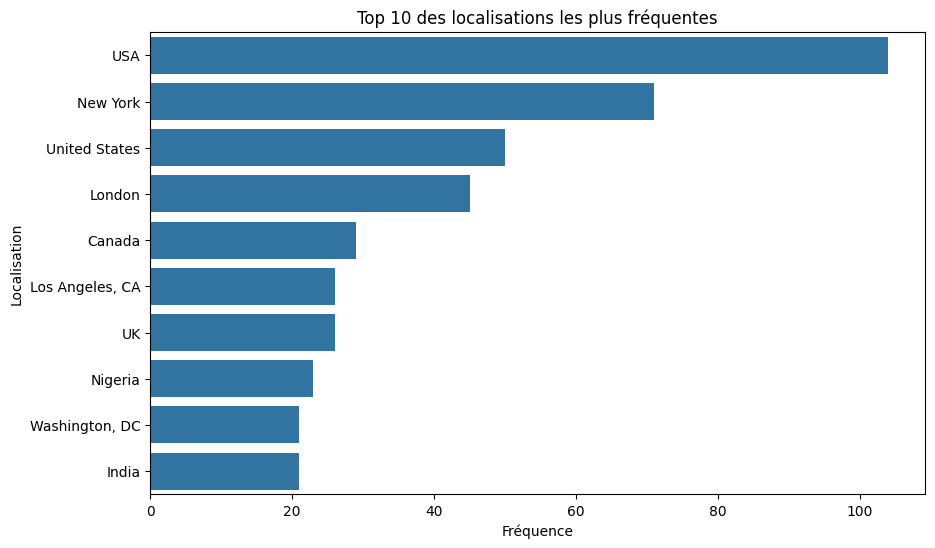

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(y='location', data=df, order=df['location'].value_counts().iloc[:10].index)
plt.title('Top 10 des localisations les plus fréquentes')
plt.xlabel('Fréquence')
plt.ylabel('Localisation')
plt.show()

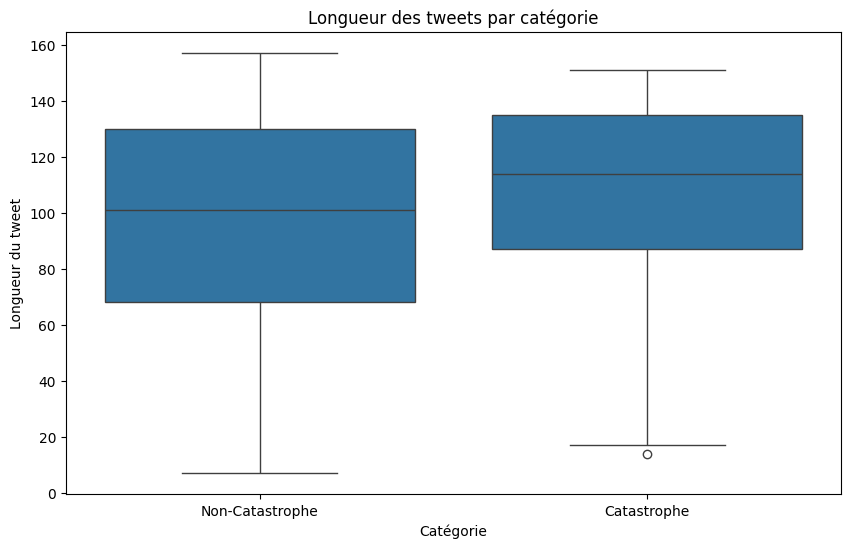

In [28]:
# Boxplot des longueurs de tweets par catégorie
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y=df['text'].apply(len), data=df)
plt.title('Longueur des tweets par catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Longueur du tweet')
plt.xticks([0, 1], ['Non-Catastrophe', 'Catastrophe'])
plt.show()


Ce graphique montre la distribution de la longueur des tweets pour les catégories "Catastrophe" et "Non-Catastrophe" à l'aide de violins plots :

Axe des Abscisses (X) : Catégorie du tweet (Non-Catastrophe ou Catastrophe). Axe des Ordonnées (Y) : Longueur des tweets en caractères. Observations

Distribution Générale :

La distribution des longueurs de tweets est similaire pour les deux catégories. Les tweets ont une large gamme de longueurs, allant de très courts à la limite maximale de caractères. Comparaison entre Catégories :

Les tweets de catastrophes et non catastrophiques ont des médianes de longueur similaires. Les tweets de catastrophes semblent légèrement plus longs en moyenne. Forme des Distributions :

Les deux distributions présentent une densité plus élevée autour de 100-140 caractères.

C:\Users\QWERTY\AppData\Local\Temp\ipykernel_324\1457864944.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=hashtag_counts.index, order=hashtag_counts.iloc[:10].index,palette='coolwarm', edgecolor='black')


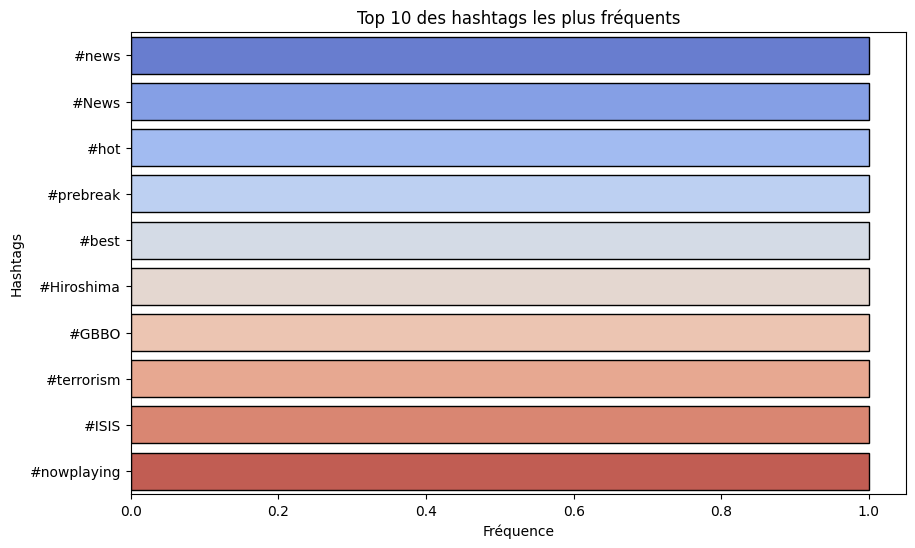

In [29]:
# Extraire les hashtags et mentions
df['hashtags'] = df['text'].apply(lambda x: [word for word in x.split() if word.startswith('#')])
df['mentions'] = df['text'].apply(lambda x: [word for word in x.split() if word.startswith('@')])

# Flatten la liste des hashtags et mentions
all_hashtags = df['hashtags'].explode().dropna()
all_mentions = df['mentions'].explode().dropna()

plt.figure(figsize=(10, 6))
all_hashtags = all_hashtags[~all_hashtags.str.contains(r'^\W+$')]
hashtag_counts = all_hashtags.value_counts()

sns.countplot(y=hashtag_counts.index, order=hashtag_counts.iloc[:10].index,palette='coolwarm', edgecolor='black')
plt.title('Top 10 des hashtags les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Hashtags')
plt.show()

C:\Users\QWERTY\AppData\Local\Temp\ipykernel_324\1613299730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=mention_counts.index, order=mention_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')


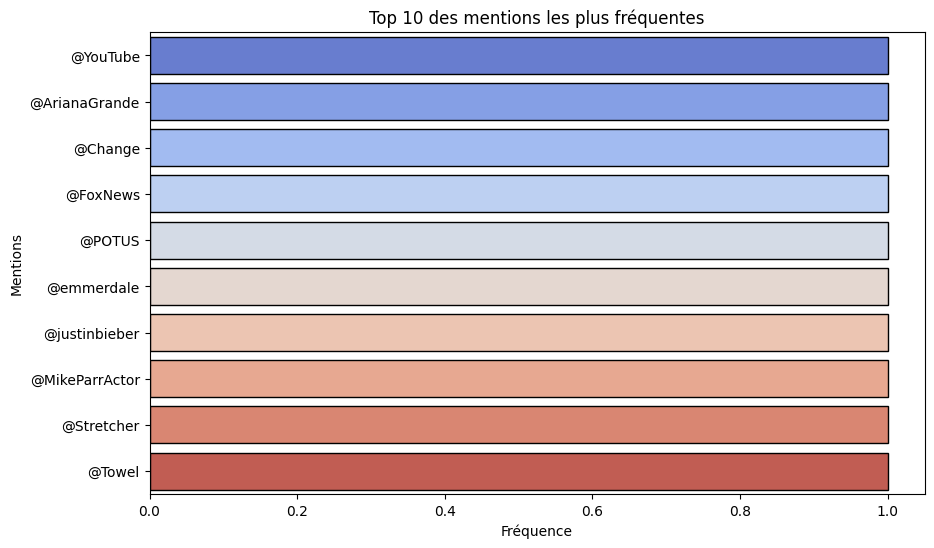

In [30]:
plt.figure(figsize=(10, 6))
all_mentions = all_mentions[all_mentions.str.contains(r'[a-zA-Z0-9]')]

mention_counts = all_mentions.value_counts()
sns.countplot(y=mention_counts.index, order=mention_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')
plt.title('Top 10 des mentions les plus fréquentes')
plt.xlabel('Fréquence')
plt.ylabel('Mentions')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\QWERTY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


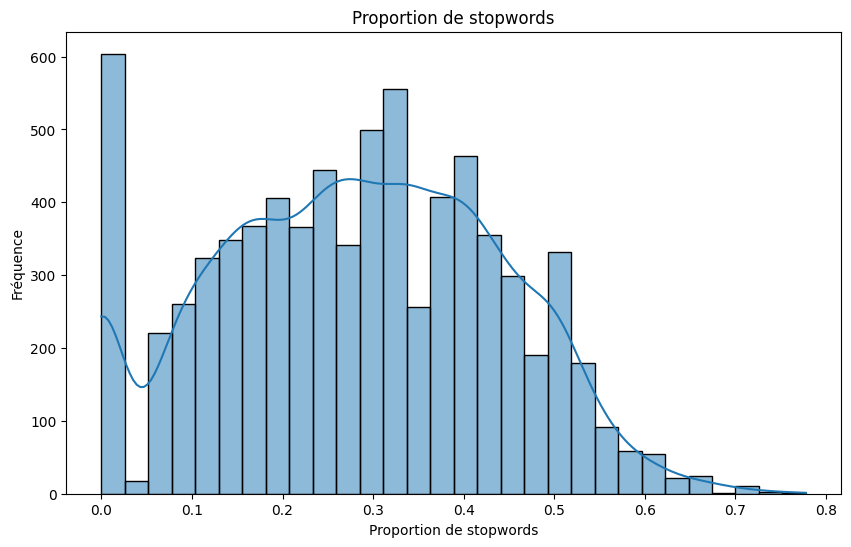

In [31]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Calculer le pourcentage de stopwords dans chaque tweet
df['stopword_percentage'] = df['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]) / len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['stopword_percentage'], bins=30, kde=True)
plt.title('Proportion de stopwords')
plt.xlabel('Proportion de stopwords')
plt.ylabel('Fréquence')
plt.show()

Proportion de Stopwords par Tweet
Ce graphique représente la proportion de stopwords (mots vides) dans chaque tweet. Les stopwords sont des mots très courants qui n'apportent pas de valeur significative à l'analyse du texte, tels que "le", "et", "mais", etc.

Observations
Distribution Générale :

La distribution montre une variété de proportions de stopwords dans les tweets.
La plupart des tweets ont une proportion de stopwords entre 10% et 50%.
Pic à 0% :

Il y a un pic notable à 0%, indiquant que certains tweets ne contiennent aucun stopword. Cela peut être dû à des tweets très courts ou à des tweets composés principalement de hashtags, mentions ou mots techniques.
Tendance Générale :

La distribution semble avoir des pics autour de 10% et 30% de stopwords.
Il y a une décroissance progressive des tweets avec une proportion de stopwords supérieure à 50%.

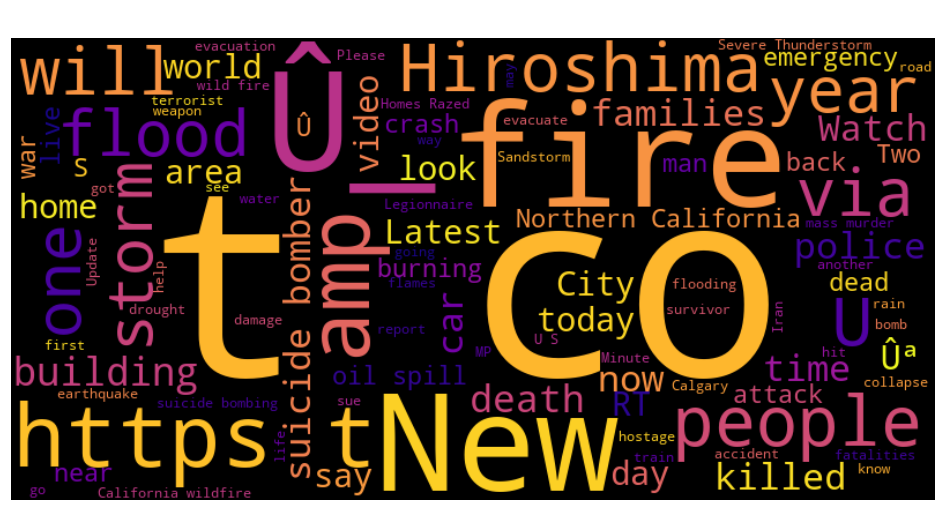

In [32]:
disaster_tweets_train = df[df['target'] == 1]['text'].values
wordcloud_train = WordCloud(
    width=800,
    height=400,
    background_color='black',
    stopwords=STOPWORDS,
    colormap='plasma',
    max_words=100,
    contour_color='white',
    contour_width=1
).generate(' '.join(disaster_tweets_train))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots pour les tweets de catastrophes - Dataset d\'Entraînement', fontsize=18, color='white')
plt.show()


Les nuages de mots permettent de visualiser rapidement les termes les plus courants dans les tweets de catastrophes, aidant à identifier les thèmes et sujets récurrents.

En montrant quels mots sont les plus fréquents, les nuages de mots aident à orienter l'analyse exploratoire en mettant en évidence les termes importants qui pourraient nécessiter une attention particulière.

Ils peuvent révéler des mots courants ou des expressions qui pourraient être ajoutés à la liste des stopwords pour affiner les modèles de traitement du langage naturel (NLP).

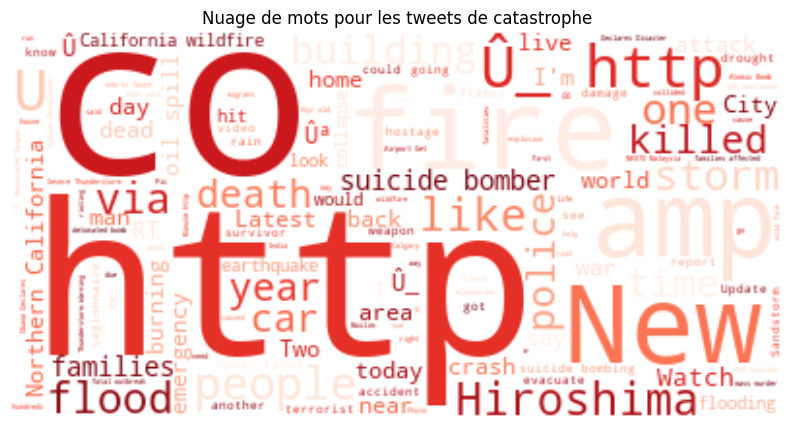

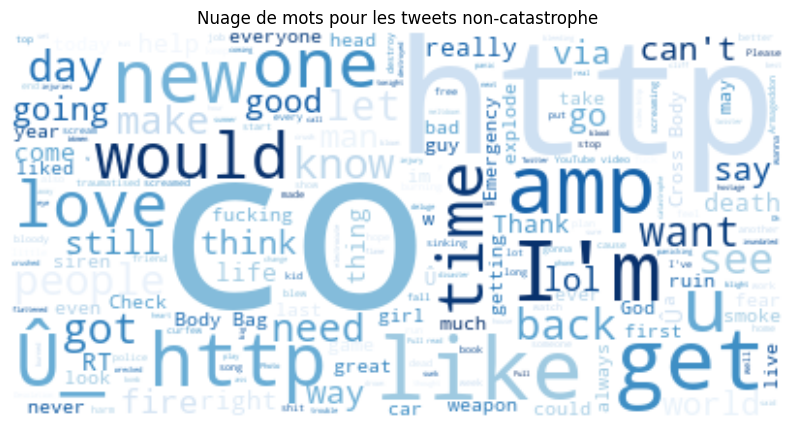

In [33]:
# Nuage de mots pour les tweets de catastrophe
disaster_tweets = ' '.join(df[df['target'] == 1]['text'])
wordcloud = WordCloud(stopwords=stop_words, background_color='white', colormap='Reds').generate(disaster_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuage de mots pour les tweets de catastrophe')
plt.axis('off')
plt.show()

# Nuage de mots pour les tweets non-catastrophe
non_disaster_tweets = ' '.join(df[df['target'] == 0]['text'])
wordcloud = WordCloud(stopwords=stop_words, background_color='white', colormap='Blues').generate(non_disaster_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuage de mots pour les tweets non-catastrophe')
plt.axis('off')
plt.show()

Analyse du Dataset de Test  
Pour le dataset de test, nous allons appliquer les mêmes analyses et visualisations que pour le dataset d'entraînement afin de comparer les distributions et les corrélations. Étant donné que les types de graphiques et les observations seront similaires, nous ne répéterons pas les explications détaillées pour chaque graphique. Cependant, les différences significatives seront mises en évidence.

Double-cliquez (ou appuyez sur Entrée) pour modifier

In [34]:
df_test = pd.read_csv('test_tweets.csv')

In [35]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [36]:
nombre_doublons = df_test['text'].duplicated().sum()
print(f"Doublons dans la colonne 'text' du DataFrame : {nombre_doublons}")

df_test = df_test.drop_duplicates(subset='text', keep='first')

Doublons dans la colonne 'text' du DataFrame : 20


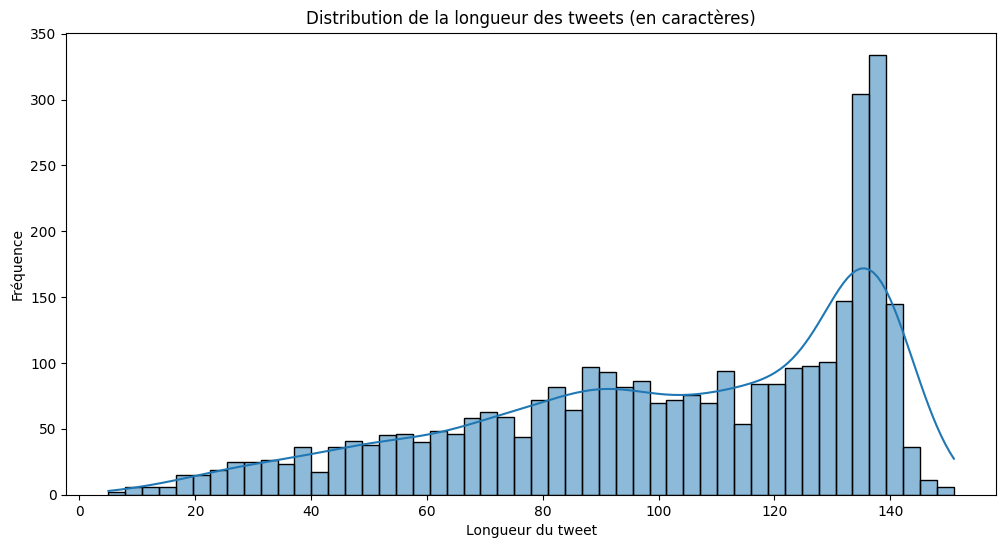

In [37]:
df_test['text_length'] = df_test['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df_test['text_length'], bins=50, kde=True)
plt.title('Distribution de la longueur des tweets (en caractères)')
plt.xlabel('Longueur du tweet')
plt.ylabel('Fréquence')
plt.show()


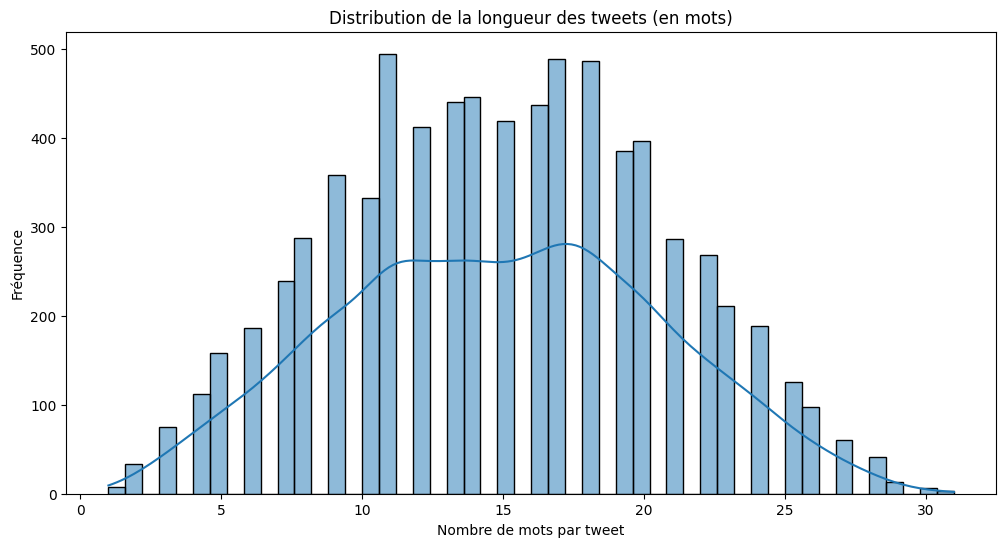

In [38]:
df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution de la longueur des tweets (en mots)')
plt.xlabel('Nombre de mots par tweet')
plt.ylabel('Fréquence')
plt.show()

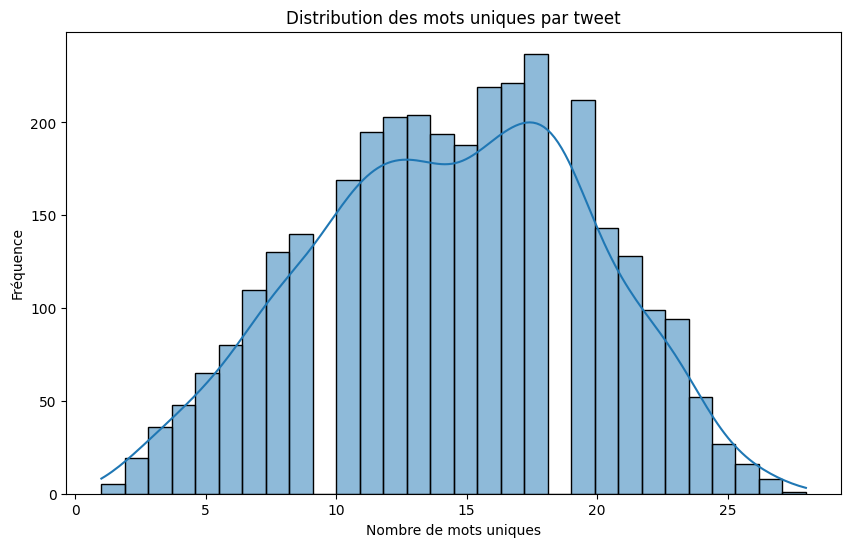

In [39]:
# Distribution des mots uniques par tweet
df_test['unique_words'] = df_test['text'].apply(lambda x: len(set(x.split())))
plt.figure(figsize=(10, 6))
sns.histplot(df_test['unique_words'], bins=30, kde=True)
plt.title('Distribution des mots uniques par tweet')
plt.xlabel('Nombre de mots uniques')
plt.ylabel('Fréquence')
plt.show()

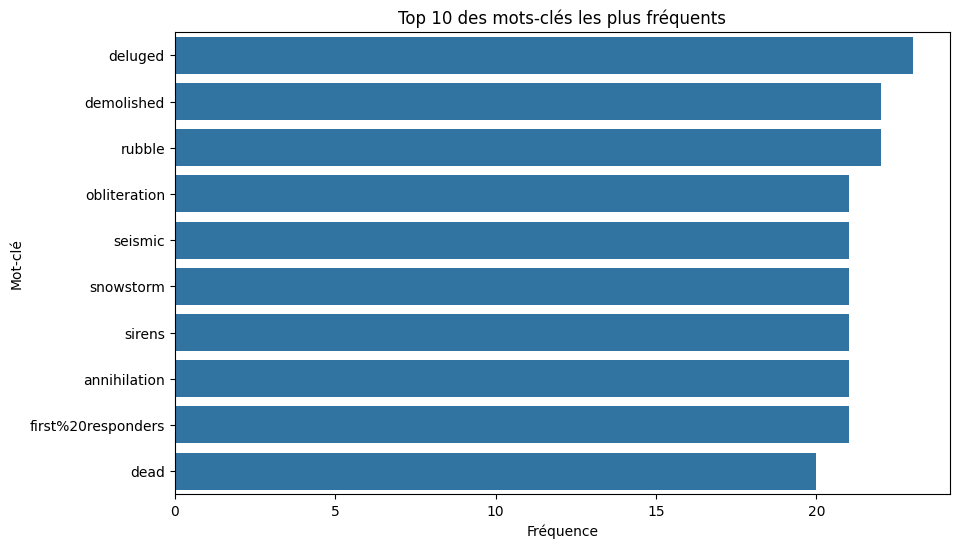

In [40]:
# Distribution des mots-clés (keywords)
plt.figure(figsize=(10, 6))
sns.countplot(y='keyword', data=df_test, order=df_test['keyword'].value_counts().iloc[:10].index)
plt.title('Top 10 des mots-clés les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Mot-clé')
plt.show()

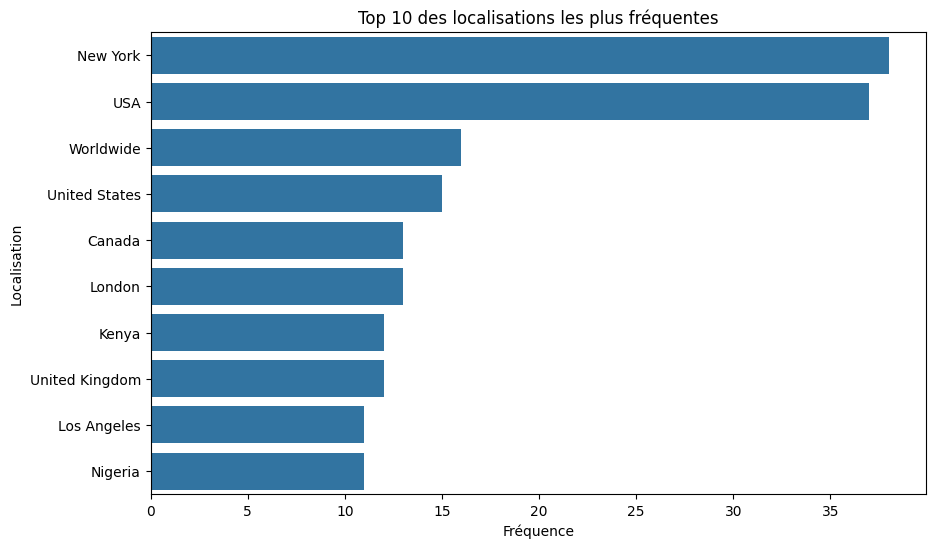

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(y='location', data=df_test, order=df_test['location'].value_counts().iloc[:10].index)
plt.title('Top 10 des localisations les plus fréquentes')
plt.xlabel('Fréquence')
plt.ylabel('Localisation')
plt.show()

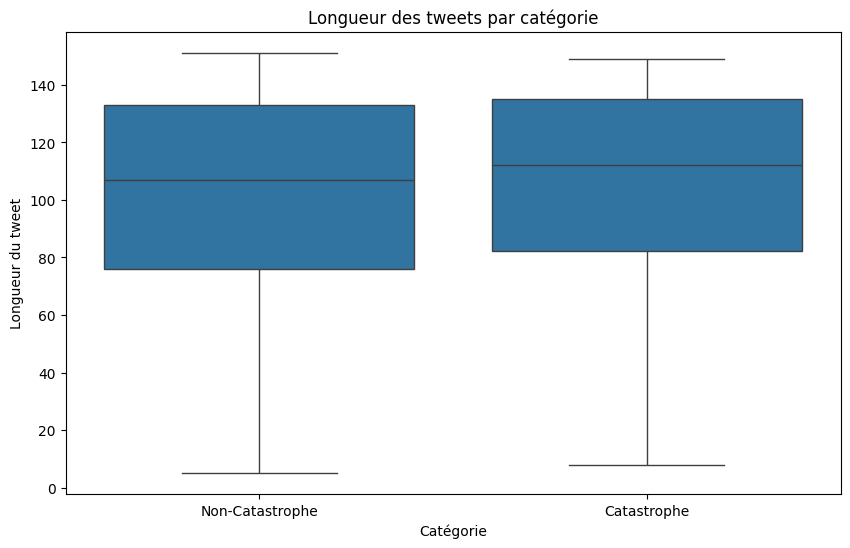

In [42]:
# Boxplot des longueurs de tweets par catégorie
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y=df_test['text'].apply(len), data=df)
plt.title('Longueur des tweets par catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Longueur du tweet')
plt.xticks([0, 1], ['Non-Catastrophe', 'Catastrophe'])
plt.show()

C:\Users\QWERTY\AppData\Local\Temp\ipykernel_324\3601774211.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=hashtag_counts.index, order=hashtag_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')


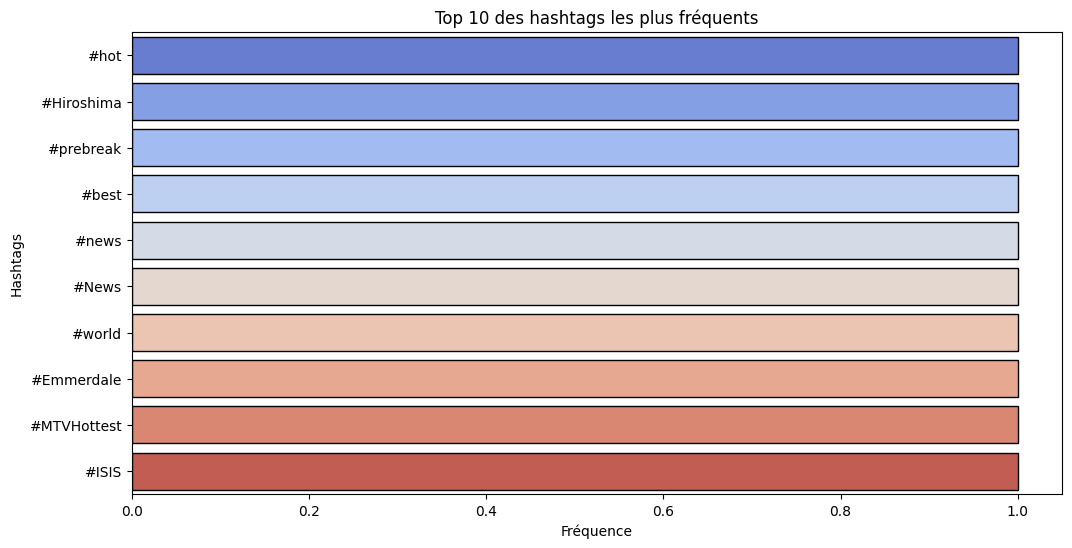

In [43]:
# Extraire les hashtags et mentions
df_test['hashtags'] = df_test['text'].apply(lambda x: [word for word in x.split() if word.startswith('#')])
# Flatten la liste des hashtags et mentions
all_hashtags = df_test['hashtags'].explode().dropna()

all_hashtags = all_hashtags[~all_hashtags.str.contains(r'^\W+$')]
hashtag_counts = all_hashtags.value_counts()

plt.figure(figsize=(12, 6))
sns.countplot(y=hashtag_counts.index, order=hashtag_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')
plt.title('Top 10 des hashtags les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Hashtags')
plt.show()

C:\Users\QWERTY\AppData\Local\Temp\ipykernel_324\2872213873.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=mention_counts.index, order=mention_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')


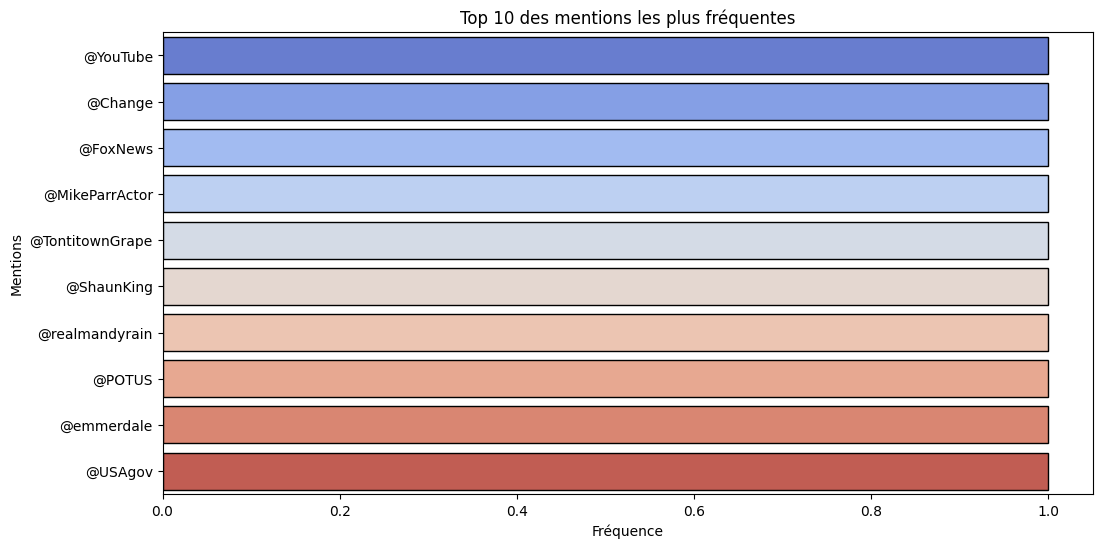

In [44]:
df_test['mentions'] = df_test['text'].apply(lambda x: [word for word in x.split() if word.startswith('@')])
all_mentions = df_test['mentions'].explode().dropna()
all_mentions = all_mentions[all_mentions.str.contains(r'[a-zA-Z0-9]')]

mention_counts = all_mentions.value_counts()

# Mentions les plus fréquentes
plt.figure(figsize=(12, 6))
sns.countplot(y=mention_counts.index, order=mention_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')
plt.title('Top 10 des mentions les plus fréquentes')
plt.xlabel('Fréquence')
plt.ylabel('Mentions')
plt.show()

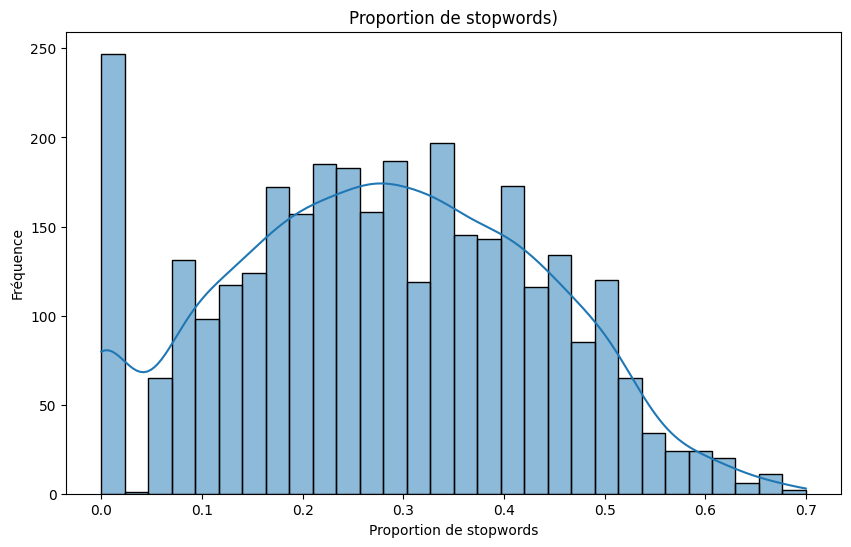

In [45]:
# Calculer le pourcentage de stopwords dans chaque tweet
df_test['stopword_percentage'] = df_test['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]) / len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_test['stopword_percentage'], bins=30, kde=True)
plt.title('Proportion de stopwords)')
plt.xlabel('Proportion de stopwords')
plt.ylabel('Fréquence')
plt.show()

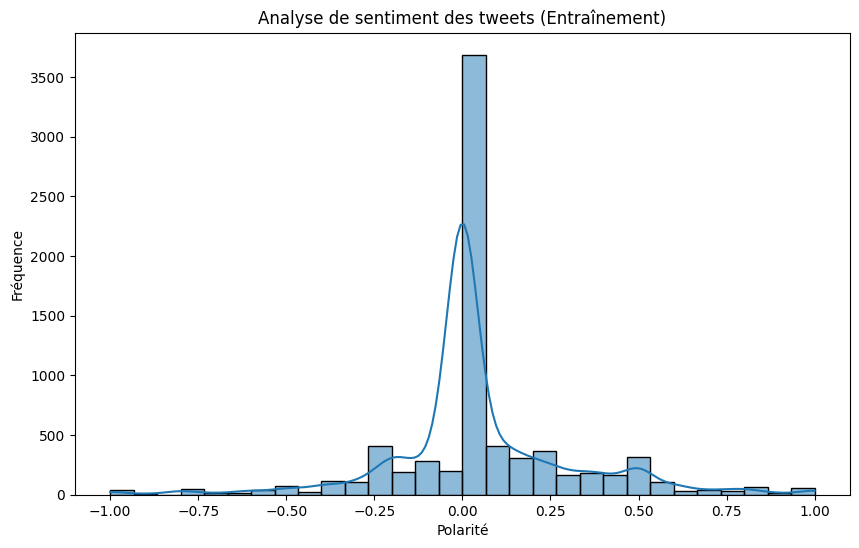

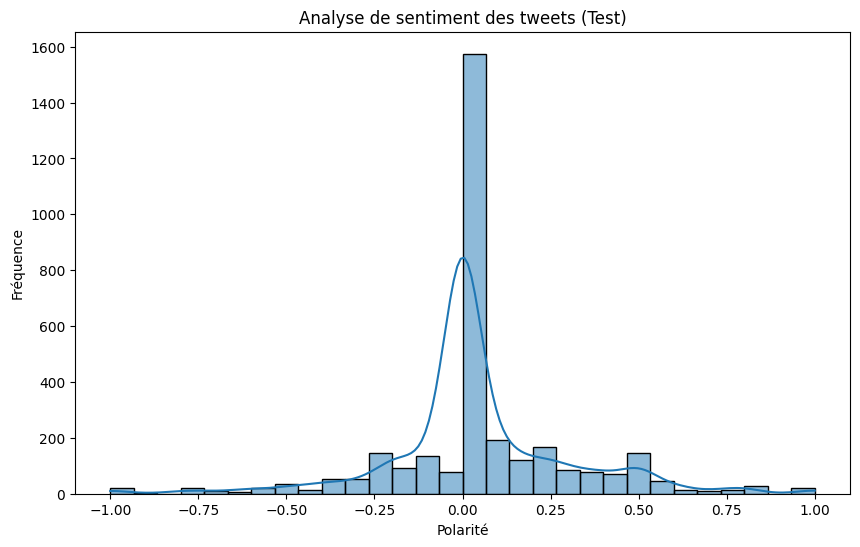

In [46]:
# Analyser le sentiment de chaque tweet
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title('Analyse de sentiment des tweets (Entraînement)')
plt.xlabel('Polarité')
plt.ylabel('Fréquence')
plt.show()

# Répéter pour le dataset de test
df_test['sentiment'] = df_test['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
plt.figure(figsize=(10, 6))
sns.histplot(df_test['sentiment'], bins=30, kde=True)
plt.title('Analyse de sentiment des tweets (Test)')
plt.xlabel('Polarité')
plt.ylabel('Fréquence')
plt.show()

Distribution Générale  
La majorité des tweets ont une polarité proche de 0, ce qui indique des sentiments neutres.
La distribution est légèrement asymétrique avec un léger biais vers les sentiments positifs.  
Tweets d'Entraînement
Il y a un pic très marqué autour de la polarité 0, ce qui signifie que de nombreux tweets ont un sentiment neutre.
Les sentiments négatifs (polarité < 0) sont présents mais moins fréquents.
Les sentiments positifs (polarité > 0) montrent une distribution relativement uniforme avec une légère diminution vers les sentiments très positifs.  
Tweets de Test  
La distribution des sentiments dans les tweets de test est similaire à celle des tweets d'entraînement.
La majorité des tweets de test ont également une polarité proche de 0, indiquant des sentiments neutres.
Il y a une légère tendance vers des sentiments positifs comme dans le dataset d'entraînement.  
Conclusion  
La majorité des tweets dans les deux datasets sont neutres en termes de sentiment.
Les sentiments positifs sont légèrement plus fréquents que les sentiments négatifs.
Cette distribution pourrait indiquer que les utilisateurs de Twitter, lorsqu'ils rapportent des événements liés aux catastrophes, tendent à le faire de manière neutre ou légèrement positive, peut-être en raison de la nature factuelle de ces tweets.

Creation de la pipeline de donnée avec SpaCy

Construction des fonctions / Chargement du modèle

In [47]:
# Charger le modèle
nlp = spacy.load('en_core_web_sm')

custom_stopwords = set(["oh", "please", "help", "#", "@"])
stemmer = SnowballStemmer('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9#@\s]', '', text)
    text = text.strip()
    return text

def spacy_pipeline(text):

    hashtags_mentions = re.findall(r'[#@]\w+', text)
    text = re.sub(r'[#@]\w+', '', text)

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.text not in custom_stopwords and token.is_alpha]

    # Mettre les hashtags et mentions à la fin du traitement
    tokens.extend(hashtags_mentions)
    return ' '.join(tokens)

# Pipeline de traitement de texte
def text_pipeline(text):
    text = clean_text(text)
    return spacy_pipeline(text)

Exemple de Données de Tweets sur des Catastrophes Naturelles  
Dans cette section, nous illustrons l'application de notre pipeline de traitement de texte sur un ensemble d'exemples de tweets concernant des catastrophes naturelles. Nous commençons par nettoyer et transformer les textes, puis nous vectorisons ces textes en utilisant TF-IDF.

In [48]:
# Exemple de données de tweets
exemple_df = pd.DataFrame({
    'text': [
        'Just happened a terrible car crash #accident. Multiple vehicles involved, emergency services on the scene @citynews.',
        'There is a fire at the street market #fire @localnews. Evacuations are underway, and fire trucks are arriving.',
        'My house is flooded! Oh no! #flood @floodaid. The water level keeps rising, and we need immediate assistance.',
        'Earthquake in San Francisco! #earthquake. Buildings are shaking, people are evacuating to open spaces. @quakealert',
        'Major hurricane is approaching the city #hurricane. Heavy winds and rain expected, stay indoors and stay safe.',
        'Tornado sighted near the outskirts of town #tornado @weatheralert. Seek shelter immediately, dangerous winds reported.',
        'Wildfire spreading rapidly in the forest #wildfire @firedept. Evacuation orders issued, smoke visible from miles away.',
        'Severe thunderstorm warning in effect #storm @stormwatch. Hail and strong winds expected, stay away from windows.',
        'Landslide blocks the main highway #landslide. Road closed, detour in place, avoid the area. @trafficupdate',
        'Blizzard conditions expected overnight #blizzard. Heavy snowfall and strong winds, travel disruptions likely. @weatherchannel'
    ]
})

# Appliquer la pipeline à toutes les lignes du dataset
exemple_df['processed_text'] = exemple_df['text'].apply(text_pipeline)

# Vectorisation du texte avec TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(exemple_df['processed_text'])

print("Texte original et texte prétraité :")
print(exemple_df[['text', 'processed_text']], "\n")

print("Portion de la matrice TF-IDF :")
print(X.toarray()[:5], "\n")

if __name__ == "__main__":
    print("Pipeline de traitement de texte exécutée avec succès.")

Texte original et texte prétraité :
                                                text  \
0  Just happened a terrible car crash #accident. ...   
1  There is a fire at the street market #fire @lo...   
2  My house is flooded! Oh no! #flood @floodaid. ...   
3  Earthquake in San Francisco! #earthquake. Buil...   
4  Major hurricane is approaching the city #hurri...   
5  Tornado sighted near the outskirts of town #to...   
6  Wildfire spreading rapidly in the forest #wild...   
7  Severe thunderstorm warning in effect #storm @...   
8  Landslide blocks the main highway #landslide. ...   
9  Blizzard conditions expected overnight #blizza...   

                                      processed_text  
0  happen terrible car crash multiple vehicle inv...  
1  fire street market evacuation underway fire tr...  
2  house flood water level keeps rise need immedi...  
3  earthquake san francisco building shake people...  
4  major hurricane approach city heavy wind rain ...  
5  tornado sight 

Explication des Résultats  
Après avoir appliqué notre pipeline de traitement de texte, nous obtenons les résultats suivants :  

Texte Original et Texte Prétraité  
Le tableau montre les tweets originaux et leurs versions prétraitées. Les tweets prétraités ont été nettoyés et transformés :  

- Les URL et balises HTML ont été supprimées.
- Le texte a été converti en minuscules.
- Les caractères spéciaux ont été supprimés, à l'exception des hashtags (#) et des mentions (@).
- Les mots ont été lemmatisés pour obtenir leur forme de base.
- Les hashtags et les mentions ont été réintégrés après le traitement.  

Portion de la Matrice TF-IDF  
La matrice TF-IDF convertit les textes prétraités en vecteurs numériques. Chaque ligne représente un tweet, et chaque colonne représente un terme unique extrait des tweets. Les valeurs de la matrice indiquent l'importance relative des termes dans chaque tweet.

Double-cliquez (ou appuyez sur Entrée) pour modifier

Double-cliquez (ou appuyez sur Entrée) pour modifier

### Adaptation de l'analyse exploratoire suite aux modifications du traitement des données textuelles.

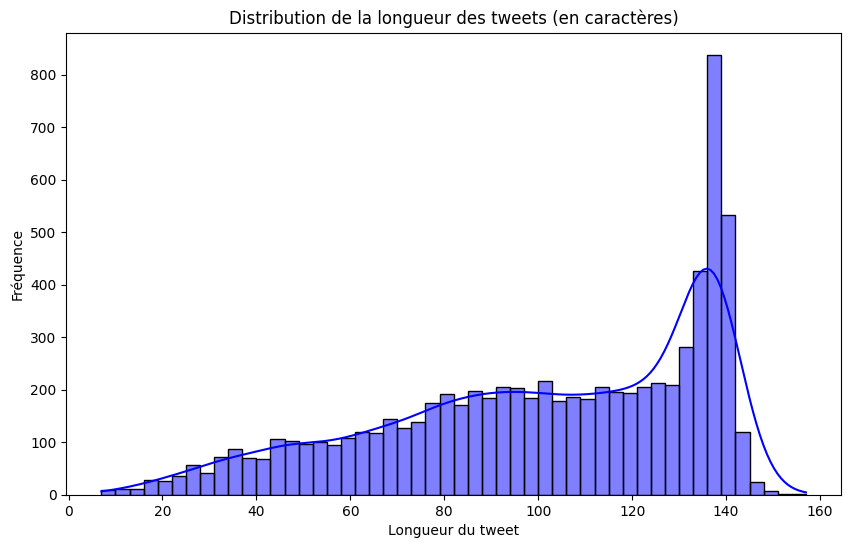

In [49]:
#verifier la longueur avant ke traitements de données
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution de la longueur des tweets (en caractères)')
plt.xlabel('Longueur du tweet')
plt.ylabel('Fréquence')
plt.show()

In [50]:
#adapter la pipeline sur le data frame de test
df['processed_text'] = df['text'].apply(text_pipeline)

In [51]:
# Statistiques descriptives des longueurs de tweets prétraités
df['processed_text_length'] = df['processed_text'].apply(len)

print("Statistiques descriptives des longueurs de tweets prétraités (Test) :")
print(df['processed_text_length'].describe())

Statistiques descriptives des longueurs de tweets prétraités (Test) :
count    7503.000000
mean       57.887645
std        23.197845
min         0.000000
25%        41.000000
50%        58.000000
75%        75.000000
max       139.000000
Name: processed_text_length, dtype: float64


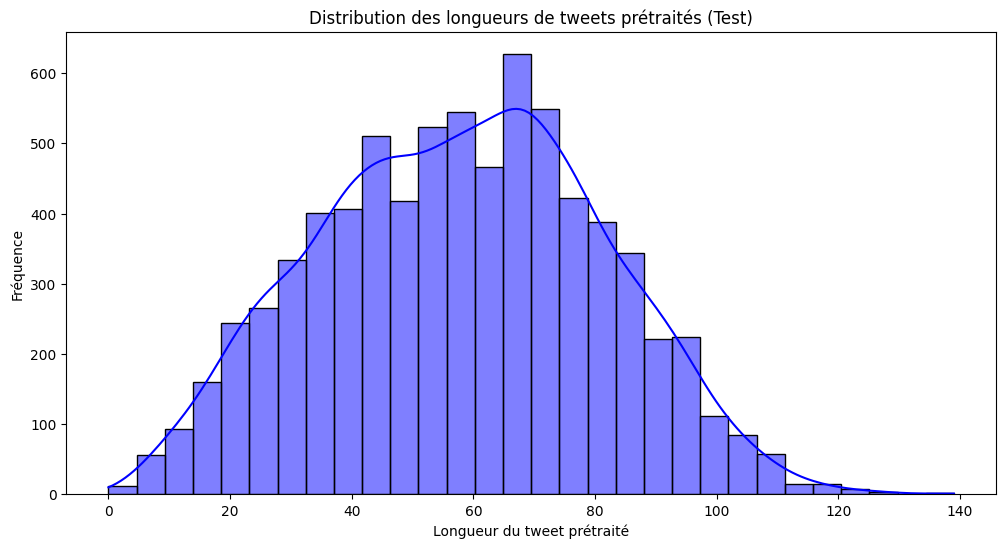

In [52]:
plt.figure(figsize=(12, 6))
sns.histplot(df['processed_text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution des longueurs de tweets prétraités (Test)')
plt.xlabel('Longueur du tweet prétraité')
plt.ylabel('Fréquence')
plt.show()

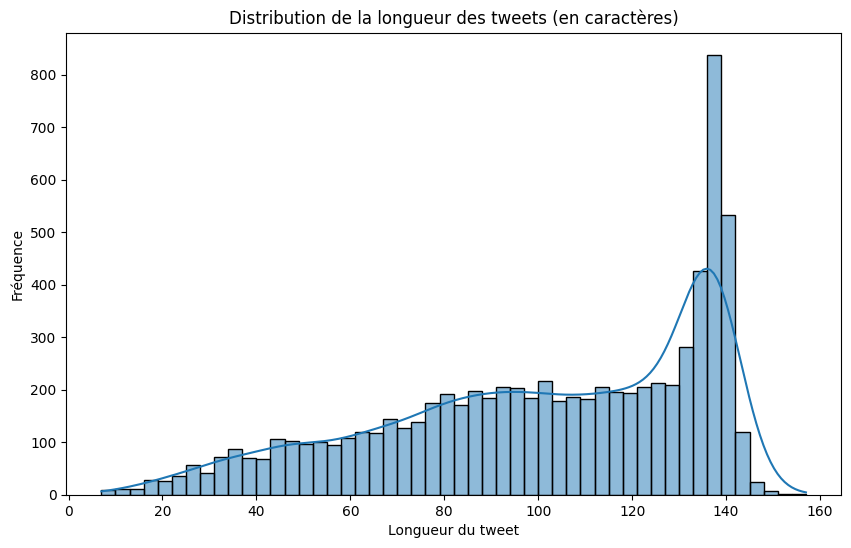

In [53]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution de la longueur des tweets (en caractères)')
plt.xlabel('Longueur du tweet')
plt.ylabel('Fréquence')
plt.show()


In [54]:
# Vectorisation du texte avec TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text'])
y = df['target']

In [58]:
# save both csv files
df.to_csv('train_tweets_cleaned.csv', index=False)
df_test.to_csv('test_tweets_cleaned.csv', index=False)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Définir les hyperparamètres pour GridSearch
param_grid_logreg = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10]
}

param_grid_dtree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20]
}

param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9]
}

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Initialiser les modèles
logreg = LogisticRegression(solver='liblinear')
dtree = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
svm = SVC()

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# Configurer GridSearchCV pour chaque modèle
grid_search_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid_logreg, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dtree = GridSearchCV(estimator=dtree, param_grid=param_grid_dtree, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
# Exécuter GridSearchCV pour chaque modèle
grid_search_logreg.fit(X_train, y_train)
grid_search_dtree.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)
grid_search_svm.fit(X_train, y_train)

c:\wamp64\www\eye-of-emergency\emergency-env\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
38 fits failed with the following error:
Traceback (most recent call last):
  File "c:\wamp64\www\eye-of-emergency\emergency-env\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\wamp64\www\eye-of-emergency\emergency-env\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\wamp64\www\eye-of-emergency\emergency-env\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    va

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

In [ ]:
# Meilleurs paramètres et meilleures performances pour chaque modèle
best_params_logreg = grid_search_logreg.best_params_
best_score_logreg = grid_search_logreg.best_score_

best_params_dtree = grid_search_dtree.best_params_
best_score_dtree = grid_search_dtree.best_score_

best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

In [ ]:
# Prédictions et évaluation des modèles sur l'ensemble de test
best_logreg = grid_search_logreg.best_estimator_
best_dtree = grid_search_dtree.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_xgb = grid_search_xgb.best_estimator_
best_svm = grid_search_svm.best_estimator_

y_pred_logreg = best_logreg.predict(X_test)
y_pred_dtree = best_dtree.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)
y_pred_svm = best_svm.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Afficher les résultats
print("Best parameters for Logistic Regression:", best_params_logreg)
print("Best score for Logistic Regression:", best_score_logreg)
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))

print("Best parameters for Decision Tree:", best_params_dtree)
print("Best score for Decision Tree:", best_score_dtree)
print("Decision Tree Test Accuracy:", accuracy_score(y_test, y_pred_dtree))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dtree))

print("Best parameters for Random Forest:", best_params_rf)
print("Best score for Random Forest:", best_score_rf)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

print("Best parameters for XGBoost:", best_params_xgb)
print("Best score for XGBoost:", best_score_xgb)
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

print("Best parameters for SVM:", best_params_svm)
print("Best score for SVM:", best_score_svm)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}
Best score for Logistic Regression: 0.7975693866222593
Logistic Regression Test Accuracy: 0.7954696868754164
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.81      0.66      0.73       627

    accuracy                           0.80      1501
   macro avg       0.80      0.78      0.78      1501
weighted avg       0.80      0.80      0.79      1501

Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 2}
Best score for Decision Tree: 0.7367546489036914
Decision Tree Test Accuracy: 0.7161892071952032
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75       874
           1       0.65      0.69      0.67       627

    accuracy                           0.72      1501
   macro avg       0.

Avec méthode Bag of Words

In [ ]:
# Appliquer le prétraitement au dataset d'entraînement
df['processed_text'] = df['text'].apply(text_pipeline)

# Séparation des données
X = df['processed_text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Pipeline avec Bag of Words et GridSearchCV
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

In [ ]:
# Paramètres pour GridSearch
parameters = [
    {
        'vectorizer__max_features': (500, 1000, 1500),
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'vectorizer__max_features': (500, 1000, 1500),
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [10, 50, None]
    },
    {
        'vectorizer__max_features': (500, 1000, 1500),
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 50, None]
    },
    {
        'vectorizer__max_features': (500, 1000, 1500),
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'classifier': [XGBClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6]
    },
    {
        'vectorizer__max_features': (500, 1000, 1500),
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
]

In [ ]:
# GridSearch
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 132 candidates, totalling 660 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': [0.1, 1, 10],
                          'vectorizer__max_features': (500, 1000, 1500),
                          'vectorizer__ngram_range': ((1, 1), (1, 2))},
                         {'classifier': [DecisionTreeClassifier()],
                          'classifier__max_depth':...
                          'classifier__max_depth': [3, 6],
                          'classifier__n_estimators': [100, 200],
                          'vectorizer__max_features': (500, 1000, 1500),
                          'vectorizer__ngram_range': ((1, 1), (1, 2))},
                         {'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'classifier__kernel': ['linear', 'rbf'],
                          'vectorizer__max_features': (500, 1000, 1500),
                          'vectorizer__ngram_range': ((1, 1), (1, 2))}],
             scoring='accuracy', verbose=2)

In [ ]:
# Meilleurs paramètres et résultats
print("Best parameters set:")
print(grid_search.best_params_)
print("Best score:")
print(grid_search.best_score_)

Best parameters set:
{'classifier': SVC(), 'classifier__C': 1, 'classifier__kernel': 'rbf', 'vectorizer__max_features': 1500, 'vectorizer__ngram_range': (1, 1)}
Best score:
0.7987328615043021


In [ ]:
# Prédictions et rapport de classification
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       874
           1       0.82      0.65      0.73       627

    accuracy                           0.80      1501
   macro avg       0.80      0.78      0.78      1501
weighted avg       0.80      0.80      0.79      1501



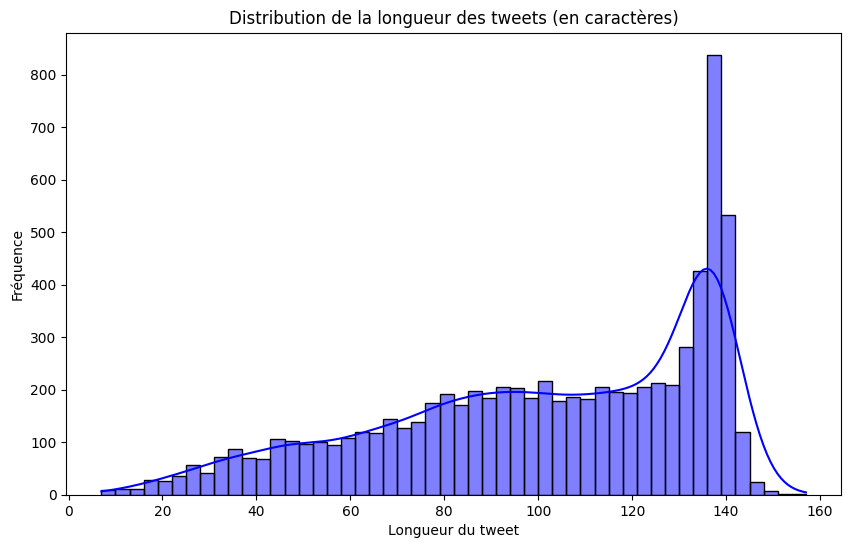

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution de la longueur des tweets (en caractères)')
plt.xlabel('Longueur du tweet')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
# Appliquer le modèle optimal sur le dataset de test
df_test = pd.read_csv('./csv/test_tweets.csv')
df_test['processed_text'] = df_test['text'].apply(text_pipeline)
X_test_final = df_test['processed_text']
y_test_pred = best_model.predict(X_test_final)

In [ ]:
# Ajouter les prédictions au dataset de test
df_test['predictions'] = y_test_pred
print(df_test[['text', 'predictions']])

                                                   text  predictions
0                    Just happened a terrible car crash            1
1     Heard about #earthquake is different cities, s...            1
2     there is a forest fire at spot pond, geese are...            1
3              Apocalypse lighting. #Spokane #wildfires            0
4         Typhoon Soudelor kills 28 in China and Taiwan            1
...                                                 ...          ...
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...            1
3259  Storm in RI worse than last hurricane. My city...            1
3260  Green Line derailment in Chicago http://t.co/U...            1
3261  MEG issues Hazardous Weather Outlook (HWO) htt...            1
3262  #CityofCalgary has activated its Municipal Eme...            0

[3263 rows x 2 columns]
